In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from openpyxl import Workbook
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch
from openpyxl import Workbook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# Read a sample of 50 sentence extractions from Diplomatic Pulse Data
ds_data = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
columns_to_check = ['positive_israel', 'negative_israel', 'positive_opt', 'negative_opt','positive_hamas','negative_hamas']

# Drop rows where all specified columns contain empty strings
ds_data = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
#ds_data = data1[~data1[columns_to_check].eq('[]').all(axis=1)]
ds_data = ds_data.rename(columns={'Unnamed: 0': 'SId'})
# Store the original data in a new DataFrame
#data = ds_data
data = ds_data.copy()

basedata = pd.read_excel('Base-for-Cosine-Similarity-DiplomaticPulseData.xlsx')

In [3]:
idx_extraction = ds_data.columns.get_loc('positive_israel')
def clean_extractions(df):
    """
    Function that cleans extractions in the input DataFrame by converting them to strings & removing brackets
    """
    for column in df.columns[idx_extraction:(idx_extraction+6)]:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.replace("[", "",regex=False)
        df[column] = df[column].str.replace("]", "",regex=False)
        df[column] = df[column].str.replace('[]', "",regex=False)
    return df

ds_data= clean_extractions(ds_data)

In [4]:
bertmodel = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bertmodel)
model = BertModel.from_pretrained(bertmodel)

#ds_data = ds_data.astype(str)
def encode_text(text):
    tokens  = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [5]:
ds_data[['positive_israel','negative_israel','positive_opt','negative_opt','positive_hamas','negative_hamas']] = ds_data[['positive_israel','negative_israel','positive_opt','negative_opt','positive_hamas','negative_hamas']].applymap(encode_text)
basedata['Reactions-Aid'] = basedata['Reactions-Aid'].apply(encode_text)

In [6]:
score_pos_israel = "bertCosSimscore_positive_israel"
score_neg_israel = "bertCosSimscore_negative_israel"
score_pos_opt = "bertCosSimscore_positive_opt"
score_neg_opt = "bertCosSimscore_negative_opt"
score_pos_hamas = "bertCosSimscore_positive_hamas"
score_neg_hamas = "bertCosSimscore_negative_hamas"

fields_list = [score_pos_israel, score_neg_israel, score_pos_opt, score_neg_opt, score_pos_hamas, score_neg_hamas]

In [7]:
idx_extraction = ds_data.columns.get_loc('positive_israel')
def get_scores(ds_data=ds_data,basedata=basedata,df=data):
    """
    Function that takes a base dataframe, cleaned dataframe and original dataframe. Returns original dataframe plus sentiment scores calculated using the cleaned dataframe and base dataframe.
    Keeps the absolute values of scores for positive sentences, and -1 * absolute value of scores for the negative sentences
    """
    similarity_scores = []
    btext = basedata.iloc[0,0].reshape(1,-1)
    for i in range(0, len(fields_list)):
        column_index = idx_extraction + i
        similarity_scores = []
        for index, row in ds_data.iterrows():
            dtext = row.iloc[column_index].reshape(1,-1)
            similarity_score = cosine_similarity(dtext, btext)    
            similarity_scores.append(similarity_score[0][0])

        df.loc[:,fields_list[i]] = similarity_scores

    #Get index of the first score column, i.e. for positive_israel
    col_idx_score = df.columns.get_loc(fields_list[0])
    for col in range(col_idx_score, (col_idx_score+6)):
        df.iloc[:, col] = df.apply(lambda row: '0' if all(row[col - 6] == '[]' for i in range(idx_extraction, idx_extraction+6)) else row[col], axis=1)

    for column in df.columns[(idx_extraction+6):]:
        df.loc[:, column] = df.loc[:, column].apply(pd.to_numeric, errors='coerce')
        
    # Keep the absolute values for positive sentences, and -1 * absolute value for the negative sentences
    positive_extractions = [col_idx_score, (col_idx_score+2), (col_idx_score+4)]
    negative_extractions = [(col_idx_score+1), (col_idx_score+3), (col_idx_score+5)]
    df.iloc[:, positive_extractions] = df.iloc[:, positive_extractions].abs()
    df.iloc[:, negative_extractions] = -df.iloc[:, negative_extractions].abs()

    # Write the DataFrame to an Excel file
    df.to_excel('bertCosineSimilarity-SentimentScores-DiplomaticPulseIsraelPalestine-SampleData.xlsx', index=False)
    return df


In [8]:
scores = get_scores(ds_data=ds_data,basedata=basedata,df=data)

In [9]:
scores.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,bertCosSimscore_positive_israel,bertCosSimscore_negative_israel,bertCosSimscore_positive_opt,bertCosSimscore_negative_opt,bertCosSimscore_positive_hamas,bertCosSimscore_negative_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.627051,-0.0,0.0,-0.0,0,-0.574767
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.604013,-0.0,0.628593,-0.0,0,-0.547492
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.531937,-0.0,0.0,-0.597278,0,-0.51175
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.64245,-0.0,0.0,-0.0,0,-0.532815
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.7547,-0.0,0.668914,-0.0,0,-0.743224


In [10]:
# Get consolidated scores for each entity-Israel, oPt, Hamas by differencing the positive and negative scores. Store these scores in the original DataFrame
col_idx_score = data.columns.get_loc(fields_list[0])
data['bertCosSim-Israel'] = data.iloc[:,col_idx_score] + data.iloc[:,(col_idx_score+1)]
data['bertCosSim-Palestine'] = data.iloc[:,(col_idx_score+2)] + data.iloc[:,(col_idx_score+3)]
data['bertCosSim-Hamas'] = data.iloc[:,(col_idx_score+4)] + data.iloc[:,(col_idx_score+5)]
data = data.drop(columns=fields_list)
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,bertCosSim-Israel,bertCosSim-Palestine,bertCosSim-Hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.627051,0.0,-0.574767
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.604013,0.628593,-0.547492
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.531937,-0.597278,-0.51175
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.64245,0.0,-0.532815
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.7547,0.668914,-0.743224


In [11]:
# Save consolidated scores in a dataframe
pred_scores = data.loc[:,['bertCosSim-Israel','bertCosSim-Palestine','bertCosSim-Hamas']]

# Read file with ground-truth scores and get the average scores for each entity                 
gtdata= pd.read_excel('AverageSentiment Scoring-RLU-DiplomaticPulse-Israel-oPt_issuingCountry.xlsx')
actual_avgscores = gtdata.iloc[:,12:15]

# Match index of ground truth scores with predicted scores because empty extractions were filtered out
acs = actual_avgscores.loc[data.index]
#acs.head()

In [12]:
mae_results = pd.DataFrame()

individual_maes = []
for i in range(3):
    abs_diff = abs(pred_scores.iloc[:, i] - acs.iloc[:, i])
    mae = np.mean(abs_diff)
    mae_results[i] = [mae]
    individual_maes.append(mae)

# Calculate overall MSE
overall_mae = np.mean(individual_maes)
mae_results['Overall'] = [overall_mae]

mae_results.index = ['MAE']
print(mae_results)

            0         1         2   Overall
MAE  0.250277  0.128202  0.192368  0.190282


In [13]:
mse_results = pd.DataFrame()

individual_mses = []
for i in range(3):
    squared_diff = (pred_scores.iloc[:, i] - acs.iloc[:, i]) ** 2
    mse = np.mean(squared_diff)
    mse_results[i] = [mse]
    individual_mses.append(mse)

# Calculate overall MSE
overall_mse = np.mean(individual_mses)
mse_results['Overall'] = [overall_mse]

mse_results.index = ['MSE']
print(mse_results)

            0        1         2   Overall
MSE  0.107959  0.04762  0.065897  0.073825


In [14]:
summary=pd.concat([mae_results,mse_results])
summary.columns = ['Israel', 'oPt','Hamas','Overall']
summary

,Israel,oPt,Hamas,Overall
MAE,0.250277,0.128202,0.192368,0.190282
MSE,0.107959,0.047620,0.065897,0.073825


In [15]:
# Get average ground truth scores in data
data['gt-score_israel'] = acs['Israel.3']
data['gt-score_opt'] = acs['Occupied Palestine Territory.3']
data['gt-score_hamas'] = acs['Hamas.3']
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,bertCosSim-Israel,bertCosSim-Palestine,bertCosSim-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.627051,0.0,-0.574767,0.666667,0.250000,-0.750000
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.604013,0.628593,-0.547492,0.000000,0.250000,-0.083333
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.531937,-0.597278,-0.51175,0.583333,-0.250000,-0.750000
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.64245,0.0,-0.532815,0.416667,0.250000,-0.833333
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.7547,0.668914,-0.743224,1.000000,0.083333,-0.916667


In [16]:
# Create 5 equal sized classes in the range -1 to 1 and classify both predicted and average ground truth scores
def to_sentiment(score):
  score = score
  if score <= -0.6:
    return "strong negative"
  elif score > -0.6 and score <= -0.2:
    return "weak negative"
  elif score > -0.2 and score < 0.2:
    return "neutral"
  elif score >=0.2 and score < 0.6:
    return "weak positive"
  elif score >= 0.6:
    return "strong positive"

data['sentiment_israel'] = data['bertCosSim-Israel'].apply(lambda x: to_sentiment(x))
data['sentiment_opt'] = data['bertCosSim-Palestine'].apply(lambda x: to_sentiment(x))
data['sentiment_hamas'] = data['bertCosSim-Hamas'].apply(lambda x: to_sentiment(x))
data[['gt_israel', 'gt_opt', 'gt_hamas']] = acs[['Israel.3','Occupied Palestine Territory.3','Hamas.3']].applymap(to_sentiment)
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,bertCosSim-Israel,bertCosSim-Palestine,bertCosSim-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas,sentiment_israel,sentiment_opt,sentiment_hamas,gt_israel,gt_opt,gt_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.627051,0.0,-0.574767,0.666667,0.250000,-0.750000,strong positive,neutral,weak negative,strong positive,weak positive,strong negative
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.604013,0.628593,-0.547492,0.000000,0.250000,-0.083333,strong positive,strong positive,weak negative,neutral,weak positive,neutral
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.531937,-0.597278,-0.51175,0.583333,-0.250000,-0.750000,weak positive,weak negative,weak negative,weak positive,weak negative,strong negative
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.64245,0.0,-0.532815,0.416667,0.250000,-0.833333,strong positive,neutral,weak negative,weak positive,weak positive,strong negative
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.7547,0.668914,-0.743224,1.000000,0.083333,-0.916667,strong positive,strong positive,strong negative,strong positive,neutral,strong negative


In [17]:
class_names=['strong negative', 'weak negative', 'neutral','weak positive','strong positive']
titles = ['Israel', 'oPt', 'Hamas']
#Israel
x1=data.iloc[:,16] #ground-truth
y1=data.iloc[:,13] #predicted
cm1 = confusion_matrix(x1, y1, labels=class_names)
#oPt
x2=data.iloc[:,17]
y2=data.iloc[:,14]
cm2 = confusion_matrix(x2, y2, labels=class_names)
#Hamas
x3=data.iloc[:,18]
y3=data.iloc[:,15]
cm3 = confusion_matrix(x3, y3, labels=class_names)

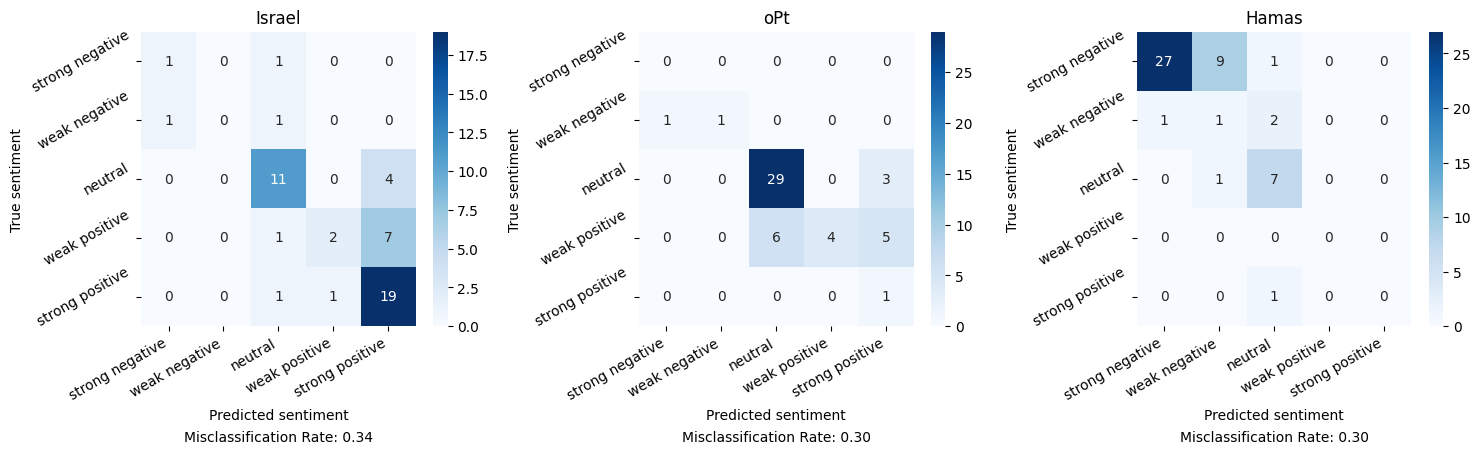

In [18]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Set the title for the subplot
    ax.set_title(titles[i])
    # Create a heatmap for each confusion matrix
    if i == 0:
        confusion_matrix = cm1
    elif i == 1:
        confusion_matrix = cm2
    else:
        confusion_matrix = cm3
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    
    # Set axis labels
    ax.set_xlabel('Predicted sentiment')
    ax.set_ylabel('True sentiment')
    
    # Calculate and display misclassification rate
    total = np.sum(confusion_matrix)
    misclassified = total - np.trace(confusion_matrix)
    misclassification_rate = misclassified / total
    ax.text(0.5, -0.39, f'Misclassification Rate: {misclassification_rate:.2f}', ha='center', transform=ax.transAxes)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
fig = plt.figure()

#plt.savefig('gpt35-equalboundary.png', transparent=False)
plt.close()

In [19]:
writer = pd.ExcelWriter('BertCosSim-equalBC-DiplomaticPulseData.xlsx', engine='openpyxl')
data.to_excel(writer, sheet_name='Main', index=False)
scores.to_excel(writer, sheet_name='All_scores', index=False)
summary.to_excel(writer, sheet_name='Summary', index=True)
writer.book.save('BertCosSim-equalBC-DiplomaticPulseData.xlsx')

Confidence Intervals for Israel, oPt and Hamas scores

In [20]:
np.random.seed(101)
entity=['Israel', 'oPt','Hamas']
for j in range(0,3):
    # Sample predicted and ground truth sentiment scores
    predicted_scores = pred_scores.iloc[:,j]
    ground_truth_scores = acs.iloc[:,j]

    # Number of bootstrap resamples
    num_resamples = 1000
    confidence_level = 0.95  

    # Calculate the differences between predicted and ground truth scores
    difference_scores = np.array(predicted_scores) - np.array(ground_truth_scores)
    bootstrap_means = np.empty(num_resamples)
    # Bootstrap resampling and mean calculation
    for i in range(num_resamples):
        #Resample with replacement
        resample_indices = np.random.choice(len(difference_scores), size=len(difference_scores), replace=True)
    
        # Calculate the mean difference for the resampled dataset
        bootstrap_means[i] = np.mean(difference_scores[resample_indices])

    # Calculate the confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (confidence_level + (1 - confidence_level) / 2) * 100
    confidence_interval = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])

    print(f"For {entity[j]}, {int(confidence_level * 100)}% Confidence Interval for Difference:", confidence_interval)
    print(f"Width of Confidence Interval : {confidence_interval[1]-confidence_interval[0]}")

For Israel, 95% Confidence Interval for Difference: [-0.06472934  0.10533422]
Width of Confidence Interval : 0.17006356127063435
For oPt, 95% Confidence Interval for Difference: [-0.04954288  0.07267767]
Width of Confidence Interval : 0.12222055047750473
For Hamas, 95% Confidence Interval for Difference: [0.08204681 0.19523564]
Width of Confidence Interval : 0.11318882986903192
